## Library Imports

In [116]:
# Core libraries
import os
import json
import numpy as np
import random
from pathlib import Path
from tqdm import tqdm

# PyTorch dependencies
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import math
from sklearn.utils.class_weight import compute_class_weight

# Data processing
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Audio processing
import librosa
import librosa.display

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For reproducibility
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

random.seed(42)
np.random.seed(42)

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cpu


## Find all chord WAV files

Finding chord files...
Found 576 chord recordings
Number of unique chord types: 24
Chord types: ['A', 'A#', 'A#m', 'Am', 'B', 'Bm', 'C', 'C#', 'C#m', 'Cm', 'D', 'D#', 'D#m', 'Dm', 'E', 'Em', 'F', 'F#', 'F#m', 'Fm', 'G', 'G#', 'G#m', 'Gm']


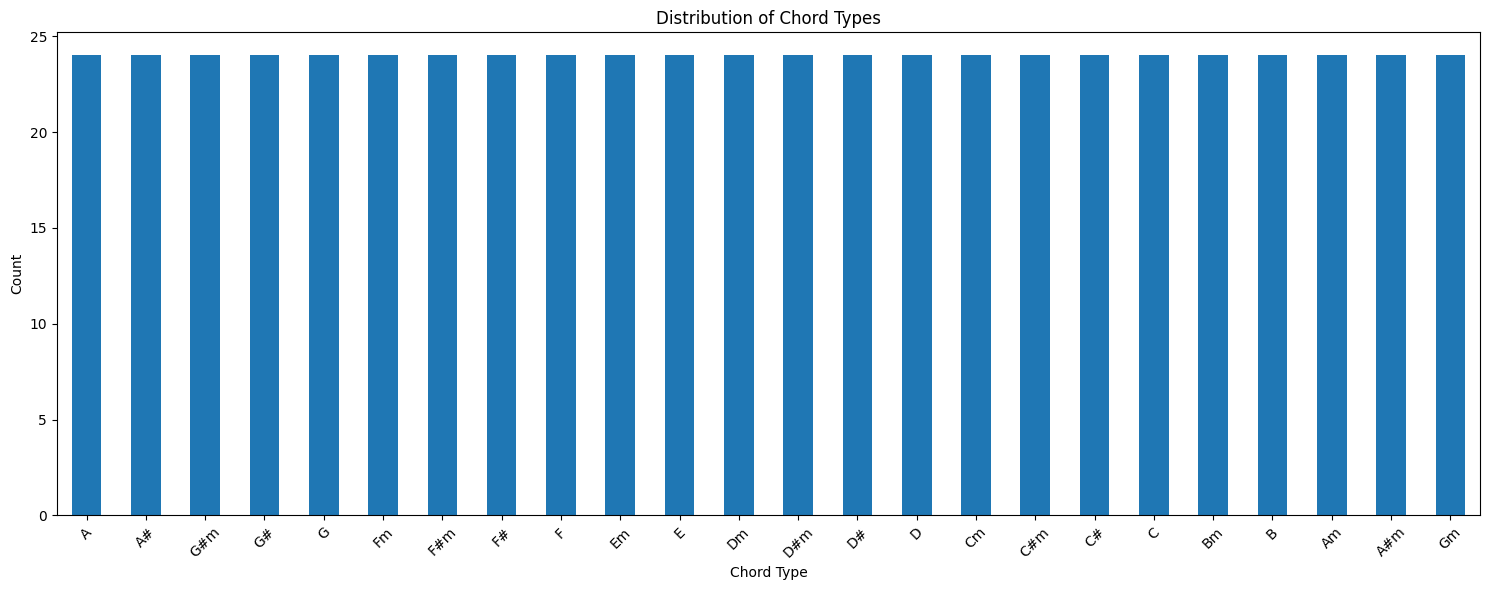

In [117]:
# Find all chord WAV files
def find_chord_files(augmented_dir):
    """Find all chord files in the augmented directory"""
    chord_files = []
    chord_labels = []
    
    print("Finding chord files...")
    for chord_type in os.listdir(augmented_dir):
        chord_folder = os.path.join(augmented_dir, chord_type)
        if os.path.isdir(chord_folder):
            for file in os.listdir(chord_folder):
                if file.endswith('.wav'):
                    file_path = os.path.join(chord_folder, file)
                    chord_files.append(file_path)
                    chord_labels.append(chord_type)  # The folder name is the chord label
    
    print(f"Found {len(chord_files)} chord recordings")
    print(f"Number of unique chord types: {len(set(chord_labels))}")
    
    return chord_files, chord_labels

# Directory containing your augmented chord WAV files
augmented_dir = "../ChordDetection/Augmented_Chords_WAV"
chord_files, chord_labels = find_chord_files(augmented_dir)

# Display distribution of chord types
unique_chords = set(chord_labels)
print("Chord types:", sorted(list(unique_chords)))

# Visualize chord distribution
chord_counts = pd.Series(chord_labels).value_counts()
plt.figure(figsize=(15, 6))
chord_counts.plot(kind='bar')
plt.title('Distribution of Chord Types')
plt.xlabel('Chord Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Feature Extraction Function

In [118]:
def extract_features(file_path):
    """Extract enhanced chromagram and related features from audio file"""
    # Load audio with original sample rate
    y, sr = librosa.load(file_path, sr=None, mono=True)
    
    # Apply pre-emphasis to emphasize higher frequencies
    y = librosa.effects.preemphasis(y)
    
    # Compute higher resolution chromagram (more bins per octave)
    chroma = librosa.feature.chroma_cqt(y=y, sr=sr, bins_per_octave=48, n_chroma=12, hop_length=512)
    
    # Add harmonic-percussive separation to focus on harmonic content
    y_harmonic, _ = librosa.effects.hpss(y)
    chroma_harmonic = librosa.feature.chroma_cqt(y=y_harmonic, sr=sr, bins_per_octave=48, n_chroma=12)
    
    # Compute tonnetz features (harmonic relationships)
    tonnetz = librosa.feature.tonnetz(y=y_harmonic, sr=sr)
    
    # Extract onset envelope for attack characteristics
    onset_env = librosa.onset.onset_strength(y=y, sr=sr)
    onset_env = onset_env.reshape(1, -1)
    
    # Add spectral contrast (timbre information)
    contrast = librosa.feature.spectral_contrast(y=y_harmonic, sr=sr)
    
    # Add MFCC for general timbral characteristics
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=12)
    
    # Stack all features
    features = np.vstack([
        chroma,             # Basic pitch class content (12)
        chroma_harmonic,    # Cleaner pitch content (12)
        tonnetz,            # Harmonic relationships (6)
        onset_env,          # Attack characteristics (1)
        contrast,           # Timbral information
        mfcc                # General timbral characteristics
    ])
    
    return features

def pad_or_truncate(feature_matrix, max_length):
    """Standardize feature matrix length"""
    if feature_matrix.shape[1] > max_length:
        return feature_matrix[:, :max_length]
    else:
        padded = np.zeros((feature_matrix.shape[0], max_length))
        padded[:, :feature_matrix.shape[1]] = feature_matrix
        return padded

## Extract Features

In [119]:
# Process a sample set first for testing
sample_size = len(chord_files)  # Use all files
sample_indices = random.sample(range(len(chord_files)), min(sample_size, len(chord_files)))
sample_files = [chord_files[i] for i in sample_indices]
sample_labels = [chord_labels[i] for i in sample_indices]

# Extract features from sample files
print("Extracting features from sample chord files...")
features_list = []
processed_files = []
processed_labels = []

for i, file_path in enumerate(tqdm(sample_files)):
    try:
        features = extract_features(file_path)
        features_list.append(features)
        processed_files.append(sample_files[i])
        processed_labels.append(sample_labels[i])
    except Exception as e:
        print(f"Error extracting features from {file_path}: {e}")

# Find maximum time steps across all feature matrices
max_time_steps = max(f.shape[1] for f in features_list)
feature_dim = features_list[0].shape[0]
print(f"Max time steps: {max_time_steps}")
print(f"Feature dimensions: {feature_dim}")

# Standardize all feature matrices to the same length
standardized_features = [pad_or_truncate(f, max_time_steps) for f in features_list]


Extracting features from sample chord files...


100%|██████████| 576/576 [06:08<00:00,  1.56it/s]

Max time steps: 619
Feature dimensions: 50


In [121]:
def preprocess_features(features_list):
    """Standardize features to have zero mean and unit variance while preserving dimensions"""
    # First, let's determine the shape of each feature matrix
    shapes = [f.shape for f in features_list]
    
    # Process each feature matrix individually
    processed_features = []
    for feature_matrix in features_list:
        # Process each row (feature type) separately
        processed_matrix = np.zeros_like(feature_matrix)
        for i in range(feature_matrix.shape[0]):
            # Get the i-th feature row
            feature_row = feature_matrix[i, :]
            # Reshape to 2D for StandardScaler (samples, features)
            feature_row_2d = feature_row.reshape(1, -1)
            # Create a scaler for this feature type
            scaler = StandardScaler()
            # Fit and transform
            scaled_row = scaler.fit_transform(feature_row_2d)
            # Put back in the processed matrix
            processed_matrix[i, :] = scaled_row.flatten()
        
        processed_features.append(processed_matrix)
    
    return processed_features

## Chord Progression Dataset

In [122]:
class ChordProgressionDataset:
    def __init__(self, chord_files, chord_labels, chord_mappings_file, progression_templates_file, sequence_length=3):
        self.chord_files = chord_files
        self.chord_labels = chord_labels
        self.sequence_length = sequence_length
        
        # Load chord mappings and progression templates from JSON files
        with open(chord_mappings_file, 'r') as f:
            self.chord_mappings = json.load(f)
            
        with open(progression_templates_file, 'r') as f:
            templates_data = json.load(f)
            self.progression_templates = templates_data['progression_templates']
        
        # Encode chord labels
        self.label_encoder = LabelEncoder()
        self.label_encoder.fit(chord_labels)
        self.encoded_labels = self.label_encoder.transform(chord_labels)
        
        # Create mapping from chord to all file indices with that chord
        self.chord_to_indices = {}
        for idx, chord in enumerate(chord_labels):
            if chord not in self.chord_to_indices:
                self.chord_to_indices[chord] = []
            self.chord_to_indices[chord].append(idx)
        
        # Generate progression sequences
        self.sequences = self._generate_sequences()
    
    def _generate_sequences(self):
        """Generate chord progression sequences using music theory patterns"""
        all_progressions = []
        keys = list(self.chord_mappings.keys())
        
        for template in self.progression_templates:
            for key in keys:
                # Convert template to actual chords
                progression = []
                valid_progression = True
                
                for degree in template:
                    if degree in self.chord_mappings[key]:
                        chord = self.chord_mappings[key][degree]
                        # Check if we have this chord in our dataset
                        if chord in self.chord_to_indices:
                            progression.append(chord)
                        else:
                            valid_progression = False
                            break
                    else:
                        valid_progression = False
                        break
                
                if valid_progression and len(progression) >= self.sequence_length + 1:
                    all_progressions.append(progression)
        
        # Build input-target pairs from progressions
        sequences = []
        for prog in all_progressions:
            for i in range(len(prog) - self.sequence_length):
                input_seq = prog[i:i+self.sequence_length]
                target = prog[i+self.sequence_length]
                sequences.append((input_seq, target))
        
        return sequences
    
    def __len__(self):
        return len(self.sequences)
    
    def get_sequence(self, idx):
        """Get a chord progression sequence by index"""
        if idx >= len(self.sequences):
            raise IndexError(f"Index {idx} out of range for dataset with {len(self.sequences)} sequences")
        
        input_chords, target_chord = self.sequences[idx]
        
        # Get sample indices for each chord in the sequence
        input_indices = []
        for chord in input_chords:
            # Randomly select one of the files with this chord
            file_idx = random.choice(self.chord_to_indices[chord])
            input_indices.append(file_idx)
        
        # Get sample index for target chord
        target_idx = random.choice(self.chord_to_indices[target_chord])
        
        return {
            'input_chords': input_chords,
            'input_indices': input_indices,
            'target_chord': target_chord,
            'target_idx': target_idx
        }
    
    def get_random_sequence(self):
        """Get a random chord progression sequence"""
        idx = random.randint(0, len(self) - 1)
        return self.get_sequence(idx)

## Create and Test Dataset

In [123]:
# Save JSON files first
chord_mappings_file = "ChordMapping.json"
progression_templates_file = "ChordProgression.json"

# Create the chord progression dataset
sequence_length = 3  # Number of chords in input sequence
progression_dataset = ChordProgressionDataset(
    processed_files, 
    processed_labels, 
    chord_mappings_file, 
    progression_templates_file, 
    sequence_length
)

# Print dataset information
print(f"Created dataset with {len(progression_dataset)} chord progression sequences")
print(f"Number of unique chord types: {len(progression_dataset.label_encoder.classes_)}")
print(f"Chord types: {progression_dataset.label_encoder.classes_}")

# Test by getting a few random sequences
print("\nSample chord progressions:")
for _ in range(5):
    sequence = progression_dataset.get_random_sequence()
    print(f"Input: {' → '.join(sequence['input_chords'])} → Target: {sequence['target_chord']}")


Created dataset with 108 chord progression sequences
Number of unique chord types: 24
Chord types: ['A' 'A#' 'A#m' 'Am' 'B' 'Bm' 'C' 'C#' 'C#m' 'Cm' 'D' 'D#' 'D#m' 'Dm' 'E'
 'Em' 'F' 'F#' 'F#m' 'Fm' 'G' 'G#' 'G#m' 'Gm']

Sample chord progressions:
Input: F# → B → G#m → Target: C#
Input: C# → F# → D#m → Target: G#
Input: D# → Gm → G# → Target: A#
Input: E → A → E → Target: B
Input: A# → Gm → D# → Target: F


## Prepare Sequence Features and Labels

In [124]:
def prepare_sequence_features(sequence, feature_matrices):
    """Prepare features for a chord sequence"""
    input_indices = sequence['input_indices']
    target_idx = sequence['target_idx']
    
    # Get and stack input features
    input_features = [feature_matrices[idx] for idx in input_indices]
    input_features = np.array(input_features)  # Shape: (sequence_length, feature_dim, max_length)
    
    # Get target features
    target_features = feature_matrices[target_idx]  # Shape: (feature_dim, max_length)
    
    return input_features, target_features

def prepare_sequence_labels(sequence, label_encoder):
    """Prepare labels for a chord sequence"""
    input_chords = sequence['input_chords']
    target_chord = sequence['target_chord']
    
    # Encode input chords
    input_labels = label_encoder.transform(input_chords)
    
    # Encode target chord
    target_label = label_encoder.transform([target_chord])[0]
    
    return input_labels, target_label

# Test with a random sequence
test_sequence = progression_dataset.get_random_sequence()
input_features, target_features = prepare_sequence_features(
    test_sequence, standardized_features
)
input_labels, target_label = prepare_sequence_labels(
    test_sequence, progression_dataset.label_encoder
)

print("Input sequence features shape:", input_features.shape)
print("Target features shape:", target_features.shape)
print("Input chord labels:", input_labels)
print("Target chord label:", target_label)
print("Original input chords:", test_sequence['input_chords'])
print("Original target chord:", test_sequence['target_chord'])


Input sequence features shape: (3, 50, 619)
Target features shape: (50, 619)
Input chord labels: [ 4 12 14]
Target chord label: 17
Original input chords: ['B', 'D#m', 'E']
Original target chord: F#


## Create Dataset Splits

In [125]:
def create_stratified_splits(dataset, val_ratio=0.15, test_ratio=0.15):
    """Create stratified dataset splits that ensure all chord types are represented"""
    # Get all chord types
    all_chord_types = list(dataset.chord_to_indices.keys())
    
    # Initialize splits
    train_indices = []
    val_indices = []
    test_indices = []
    
    # For each chord type, split its sequence indices proportionally
    for chord in all_chord_types:
        # Get all progression sequences that target this chord
        chord_sequences = []
        for idx in range(len(dataset)):
            sequence = dataset.get_sequence(idx)
            if sequence['target_chord'] == chord:
                chord_sequences.append(idx)
        
        # Shuffle sequences for this chord
        random.shuffle(chord_sequences)
        
        # Calculate split sizes
        total = len(chord_sequences)
        test_count = max(1, int(test_ratio * total))
        val_count = max(1, int(val_ratio * total))
        train_count = max(1, total - test_count - val_count)
        
        # Adjust if needed to ensure all splits have at least one example
        if train_count + test_count + val_count > total:
            if train_count > 1:
                train_count -= 1
            elif test_count > 1:
                test_count -= 1
            elif val_count > 1:
                val_count -= 1
                
        # Add to respective splits
        train_indices.extend(chord_sequences[:train_count])
        val_indices.extend(chord_sequences[train_count:train_count+val_count])
        test_indices.extend(chord_sequences[train_count+val_count:])
    
    return {
        'train': train_indices,
        'val': val_indices,
        'test': test_indices
    }

## Show Chord Distribution

In [126]:
def check_chord_distribution(dataset, splits):
    """Check if all chord types are represented in all splits"""
    all_chord_types = set(dataset.chord_to_indices.keys())
    
    split_distribution = {}
    for split_name, indices in splits.items():
        chords_in_split = set()
        for idx in indices:
            sequence = dataset.get_sequence(idx)
            chords_in_split.add(sequence['target_chord'])
        
        missing_chords = all_chord_types - chords_in_split
        split_distribution[split_name] = {
            'chord_count': len(chords_in_split),
            'missing_chords': list(missing_chords)
        }
    
    return split_distribution

# Create the dataset splits first
splits = create_stratified_splits(progression_dataset, val_ratio=0.15, test_ratio=0.15)

# Check chord distribution in splits
print("\nChecking chord distribution in splits:")
chord_distribution = check_chord_distribution(progression_dataset, splits)
for split, info in chord_distribution.items():
    print(f"{split} split: {info['chord_count']}/24 chord types")
    if info['missing_chords']:
        print(f"  Missing: {', '.join(info['missing_chords'])}")


Checking chord distribution in splits:
train split: 12/24 chord types
  Missing: Gm, Em, C#m, G#m, D#m, Cm, Fm, Dm, Bm, A#m, F#m, Am
val split: 12/24 chord types
  Missing: Gm, Em, C#m, G#m, D#m, Cm, Fm, Dm, Bm, A#m, F#m, Am
test split: 12/24 chord types
  Missing: Gm, Em, C#m, G#m, D#m, Cm, Fm, Dm, Bm, A#m, F#m, Am


## Chord Sequence Implementation

In [127]:
class ChordSequenceDataset(Dataset):
    def __init__(self, chord_dataset, feature_matrices, indices, sequence_length=3):
        self.chord_dataset = chord_dataset
        self.feature_matrices = feature_matrices
        self.indices = indices
        self.sequence_length = sequence_length
        
    def __len__(self):
        return len(self.indices)
    
    def __getitem__(self, idx):
        # Get the sequence index from our dataset splits
        sequence_idx = self.indices[idx]
        
        # Get the actual sequence data
        sequence = self.chord_dataset.get_sequence(sequence_idx)
        
        # Get input features and target label
        input_indices = sequence['input_indices']
        target_idx = self.chord_dataset.label_encoder.transform([sequence['target_chord']])[0]
        
        # Stack input features - shape: (sequence_length, feature_dim, max_time_steps)
        input_features = np.array([self.feature_matrices[i] for i in input_indices])
        
        # For LSTM, reshape to (sequence_length, feature_dim * max_time_steps)
        # This flattens the time dimension for each feature matrix
        reshaped_features = input_features.reshape(self.sequence_length, -1)
        
        return torch.tensor(reshaped_features, dtype=torch.float32), torch.tensor(target_idx, dtype=torch.long)


## Prepare Data Loaders

In [128]:
def prepare_dataloaders(chord_dataset, feature_matrices, splits, batch_size=32):
    """Create train, validation, and test dataloaders"""
    # Create datasets
    train_dataset = ChordSequenceDataset(
        chord_dataset, feature_matrices, splits['train'], chord_dataset.sequence_length
    )
    val_dataset = ChordSequenceDataset(
        chord_dataset, feature_matrices, splits['val'], chord_dataset.sequence_length
    )
    test_dataset = ChordSequenceDataset(
        chord_dataset, feature_matrices, splits['test'], chord_dataset.sequence_length
    )
    
    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    
    return train_loader, val_loader, test_loader


## LSTM Model Architecture


In [129]:
class EnhancedChordProgressionLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout=0.4):
        super(EnhancedChordProgressionLSTM, self).__init__()
        
        # Batch normalization for input
        self.batch_norm_input = nn.BatchNorm1d(input_size)
        
        # Bidirectional LSTM layers with increasing capacity
        self.lstm1 = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=1,
            batch_first=True,
            bidirectional=True
        )
        
        self.batch_norm1 = nn.BatchNorm1d(hidden_size * 2)
        self.dropout1 = nn.Dropout(dropout)
        
        self.lstm2 = nn.LSTM(
            input_size=hidden_size * 2,
            hidden_size=hidden_size * 2,
            num_layers=num_layers - 1,
            batch_first=True,
            bidirectional=True,
            dropout=dropout if num_layers > 2 else 0
        )
        
        # Multi-head self-attention mechanism
        self.attention_heads = 4
        self.attention_layers = nn.ModuleList([
            nn.Sequential(
                nn.Linear(hidden_size * 4, 1),
                nn.Tanh()
            ) for _ in range(self.attention_heads)
        ])
        
        # Fully connected layers with skip connections
        self.fc1 = nn.Linear(hidden_size * 4 * self.attention_heads, hidden_size * 2)
        self.bn1 = nn.BatchNorm1d(hidden_size * 2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        
        self.fc2 = nn.Linear(hidden_size * 2, hidden_size)
        self.bn2 = nn.BatchNorm1d(hidden_size)
        
        self.fc3 = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        # x shape: (batch_size, sequence_length, input_size)
        batch_size, seq_len, features = x.size()
        
        # Apply batch normalization
        x_reshaped = x.view(-1, features)
        x_normalized = self.batch_norm_input(x_reshaped)
        x = x_normalized.view(batch_size, seq_len, features)
        
        # First LSTM layer
        lstm1_out, _ = self.lstm1(x)  # (batch_size, seq_len, hidden_size*2)
        
        # Apply normalization and dropout between LSTM layers
        lstm1_out_reshaped = lstm1_out.reshape(-1, lstm1_out.shape[2])
        lstm1_out_normalized = self.batch_norm1(lstm1_out_reshaped)
        lstm1_out = self.dropout1(lstm1_out_normalized.reshape(batch_size, seq_len, -1))
        
        # Second LSTM layer
        lstm2_out, _ = self.lstm2(lstm1_out)  # (batch_size, seq_len, hidden_size*4)
        
        # Apply multi-head attention
        attention_outputs = []
        for attention in self.attention_layers:
            # Calculate attention weights
            attn_weights = attention(lstm2_out).squeeze(-1)  # (batch_size, seq_len)
            attn_weights = F.softmax(attn_weights, dim=1).unsqueeze(1)  # (batch_size, 1, seq_len)
            
            # Apply attention to get context vector
            context = torch.bmm(attn_weights, lstm2_out).squeeze(1)  # (batch_size, hidden_size*4)
            attention_outputs.append(context)
        
        # Concatenate outputs from all attention heads
        context = torch.cat(attention_outputs, dim=1)  # (batch_size, hidden_size*4*heads)
        
        # Fully connected layers with residual connections
        out = self.fc1(context)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.dropout(out)
        
        residual = out  # Save for residual connection
        
        out = self.fc2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.dropout(out)
        
        # Add residual connection if dimensions match, otherwise use adaptation layer
        if residual.shape[1] == out.shape[1]:
            out = out + residual
        
        out = self.fc3(out)
        
        return out

## Training Function

In [130]:
def train_model(model, train_loader, val_loader, num_epochs=200, learning_rate=0.001, patience=20, model_name="model"):
    # Calculate class weights to handle imbalance
    all_labels = []
    for _, targets in train_loader:
        all_labels.extend(targets.numpy())
    
    # Get all possible classes from the model's output size
    num_classes = model.fc3.out_features
    
    all_possible_classes = np.arange(num_classes)
    
    # Count occurrences of each class
    class_counts = np.zeros(num_classes)
    unique_classes, counts = np.unique(all_labels, return_counts=True)
    for cls, count in zip(unique_classes, counts):
        class_counts[cls] = count
    
    # Print class distribution warning if some classes are missing
    if len(unique_classes) < num_classes:
        print(f"Warning: Only {len(unique_classes)}/{num_classes} classes present in training data.")
        missing_classes = set(all_possible_classes) - set(unique_classes)
        print(f"Missing classes: {missing_classes}")
    
    # Manually compute weights (inversely proportional to frequency)
    # Add a small number to avoid division by zero
    epsilon = 1e-5
    class_weights = 1.0 / (class_counts + epsilon)
    
    # Normalize weights
    class_weights = class_weights / class_weights.sum() * num_classes
    
    # Convert to tensor
    class_weights = torch.FloatTensor(class_weights).to(device)
    
    # Loss and optimizer
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    
    # Improved learning rate scheduler with cosine annealing and warm restarts
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer, 
        T_0=10,  # Restart every 10 epochs
        T_mult=2,  # Double the restart interval after each restart
        eta_min=learning_rate/100  # Minimum learning rate
    )
    
    # For early stopping
    best_val_loss = float('inf')
    best_val_acc = 0.0
    counter = 0
    best_model_path = f'best_{model_name}_model.pth'
    
    # Training history
    history = {
        'train_loss': [], 'train_acc': [], 
        'val_loss': [], 'val_acc': []
    }
    
    # Training loop
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0
        
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            
            # Gradient clipping to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            
            # Track loss and accuracy
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += targets.size(0)
            train_correct += (predicted == targets).sum().item()
        
        # Update learning rate
        scheduler.step()
        
        # Calculate average training metrics
        avg_train_loss = train_loss / len(train_loader)
        train_accuracy = 100.0 * train_correct / train_total
        
        # Validation phase
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                
                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                
                # Track loss and accuracy
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += targets.size(0)
                val_correct += (predicted == targets).sum().item()
        
        # Calculate average validation metrics
        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = 100.0 * val_correct / val_total
        
        # Print epoch statistics
        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, '
              f'Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.2f}%, '
              f'LR: {scheduler.get_last_lr()[0]:.6f}')
        
        # Update history
        history['train_loss'].append(avg_train_loss)
        history['train_acc'].append(train_accuracy)
        history['val_loss'].append(avg_val_loss)
        history['val_acc'].append(val_accuracy)
        
        # Improved model saving criteria (consider both loss and accuracy)
        if val_accuracy > best_val_acc or (val_accuracy == best_val_acc and avg_val_loss < best_val_loss):
            best_val_loss = avg_val_loss
            best_val_acc = val_accuracy
            counter = 0
            # Save best model
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': best_val_loss,
                'val_accuracy': val_accuracy,
                'history': history
            }, best_model_path)
            print(f"Model saved with val_accuracy: {best_val_acc:.2f}%, val_loss: {best_val_loss:.4f}")
        else:
            counter += 1
            if counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
    
    # Load best model
    checkpoint = torch.load(best_model_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"Best model loaded from epoch {checkpoint['epoch']+1} with val_accuracy: {checkpoint['val_accuracy']:.2f}%")
    
    return model, history

## Create Dataset Loaders and Initialization of Model

In [131]:
# Create dataloaders with increased batch size for better training
batch_size = 16  # Smaller batch size for more gradient updates
train_loader, val_loader, test_loader = prepare_dataloaders(
    progression_dataset, standardized_features, splits, batch_size
)

# Get the input size (flattened feature matrix)
sample_input, _ = next(iter(train_loader))
input_size = sample_input.shape[2]  # sequence_length × flattened feature size
print(f"Input size: {input_size}")

# Create both model types
num_classes = len(progression_dataset.label_encoder.classes_)

Input size: 30950


## Train Model

Input size: 30950
Enhanced LSTM Model Architecture:
EnhancedChordProgressionLSTM(
  (batch_norm_input): BatchNorm1d(30950, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lstm1): LSTM(30950, 256, batch_first=True, bidirectional=True)
  (batch_norm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.4, inplace=False)
  (lstm2): LSTM(512, 512, num_layers=2, batch_first=True, dropout=0.4, bidirectional=True)
  (attention_layers): ModuleList(
    (0-3): 4 x Sequential(
      (0): Linear(in_features=1024, out_features=1, bias=True)
      (1): Tanh()
    )
  )
  (fc1): Linear(in_features=4096, out_features=512, bias=True)
  (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.4, inplace=False)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tru

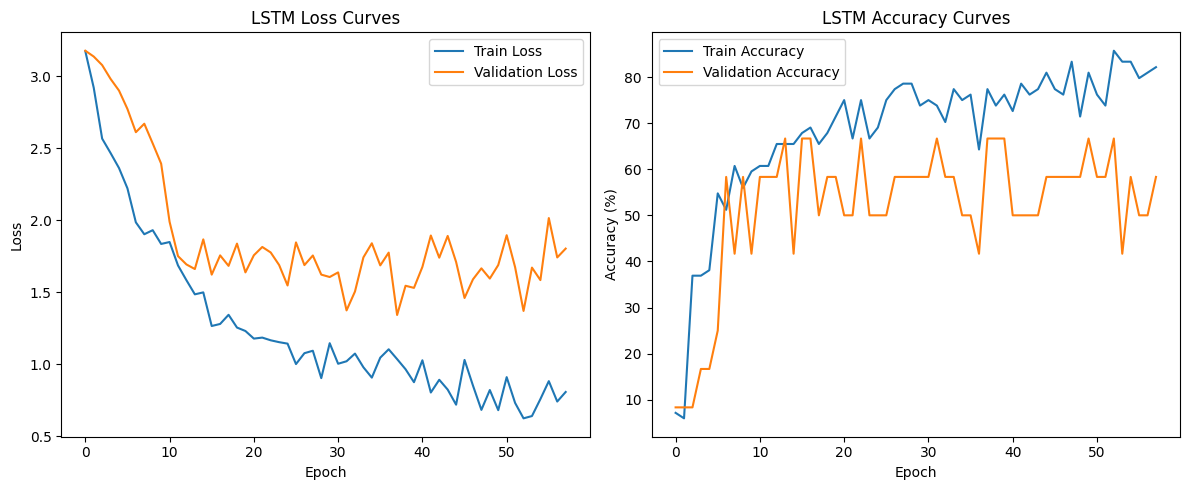

In [132]:
# Create dataloaders with a balanced batch sampling strategy
batch_size = 16
train_loader, val_loader, test_loader = prepare_dataloaders(
    progression_dataset, standardized_features, splits, batch_size
)

# Get the input size
sample_input, _ = next(iter(train_loader))
input_size = sample_input.shape[2]
print(f"Input size: {input_size}")

# Enhanced LSTM model parameters
lstm_hidden_size = 256
lstm_num_layers = 3
lstm_dropout = 0.4

# Initialize enhanced LSTM model
lstm_model = EnhancedChordProgressionLSTM(
    input_size=input_size,
    hidden_size=lstm_hidden_size,
    num_layers=lstm_num_layers,
    num_classes=len(progression_dataset.label_encoder.classes_),
    dropout=lstm_dropout
).to(device)

print("Enhanced LSTM Model Architecture:")
print(lstm_model)

# Train with improved parameters
lstm_epochs = 200
lstm_learning_rate = 0.0003
lstm_patience = 20

print("\nTraining Enhanced LSTM model...")
lstm_model, lstm_history = train_model(
    lstm_model, train_loader, val_loader, 
    num_epochs=lstm_epochs, 
    learning_rate=lstm_learning_rate,
    patience=lstm_patience,
    model_name="enhanced_lstm"
)

# Plot LSTM training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(lstm_history['train_loss'], label='Train Loss')
plt.plot(lstm_history['val_loss'], label='Validation Loss')
plt.title('LSTM Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(lstm_history['train_acc'], label='Train Accuracy')
plt.plot(lstm_history['val_acc'], label='Validation Accuracy')
plt.title('LSTM Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.savefig('enhanced_lstm_training_history.png')
plt.show()

## Evaluate on Test Set


=== Enhanced LSTM Model Evaluation ===


c:\Users\suyas\miniconda3\envs\ryzen-ai-1.3.0\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\suyas\miniconda3\envs\ryzen-ai-1.3.0\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\suyas\miniconda3\envs\ryzen-ai-1.3.0\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

<Figure size 1500x1200 with 0 Axes>

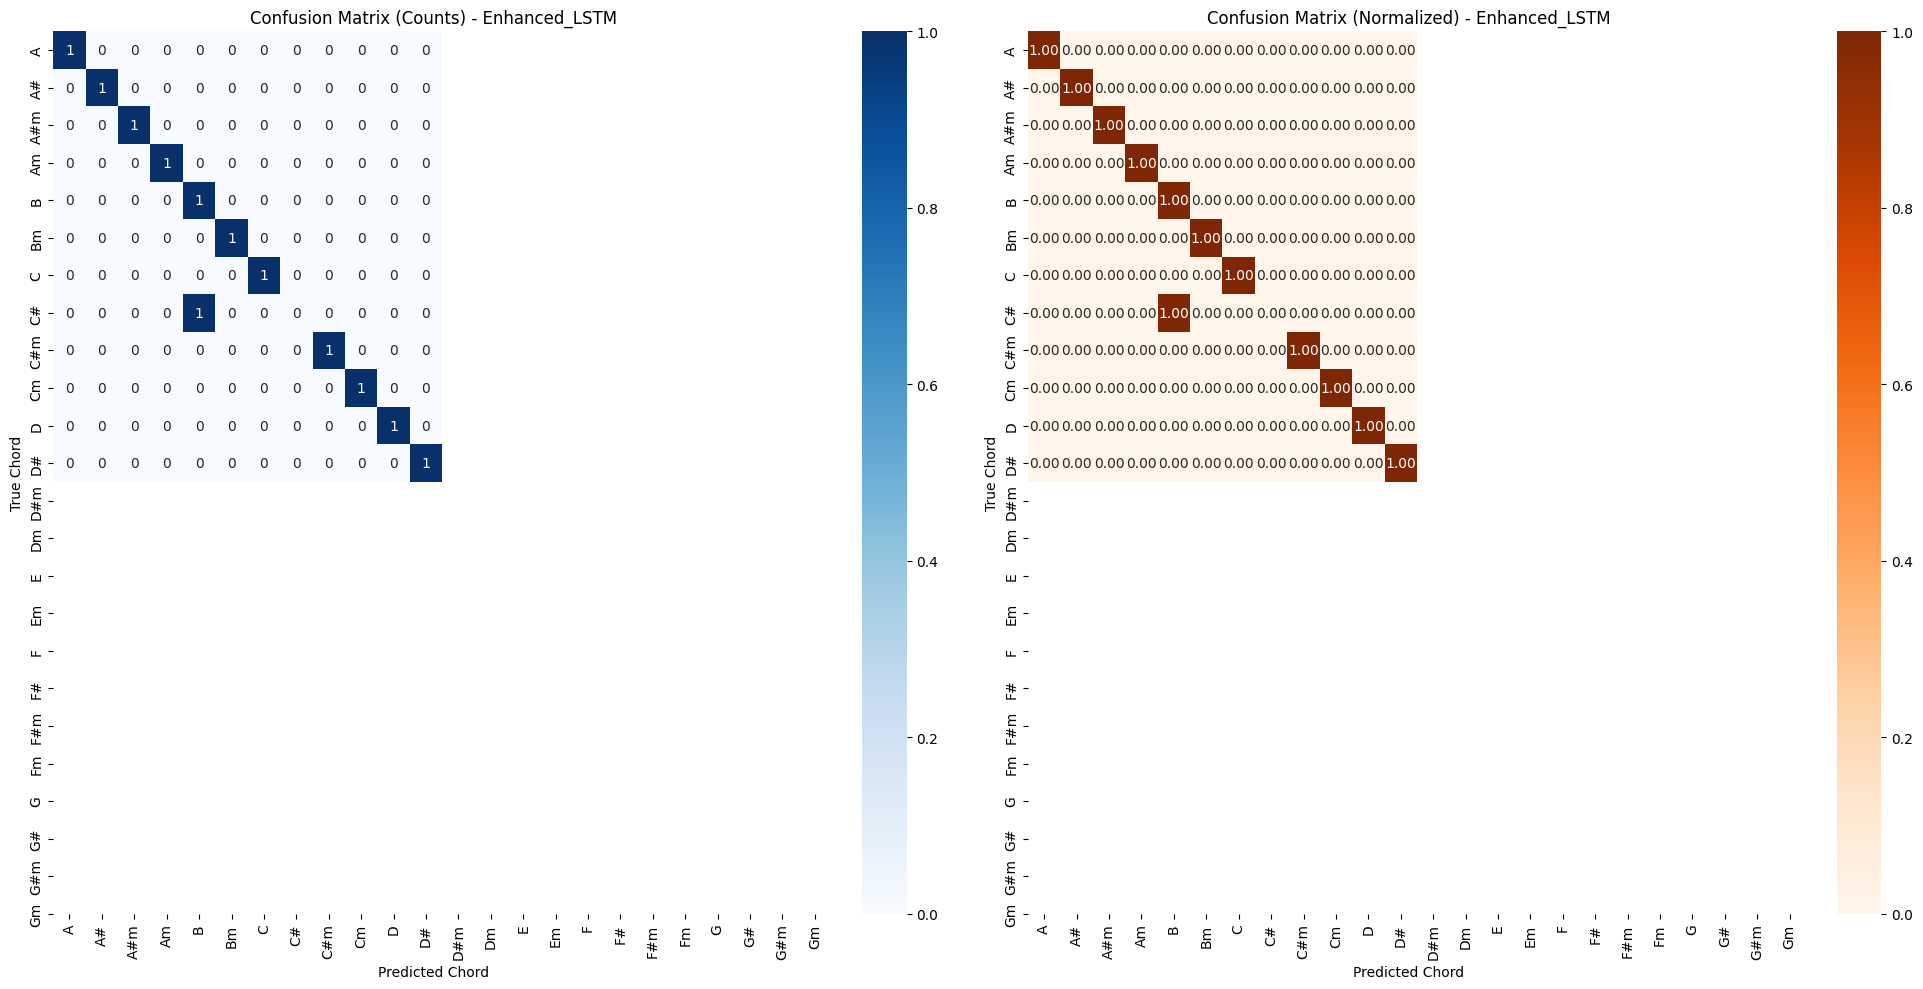

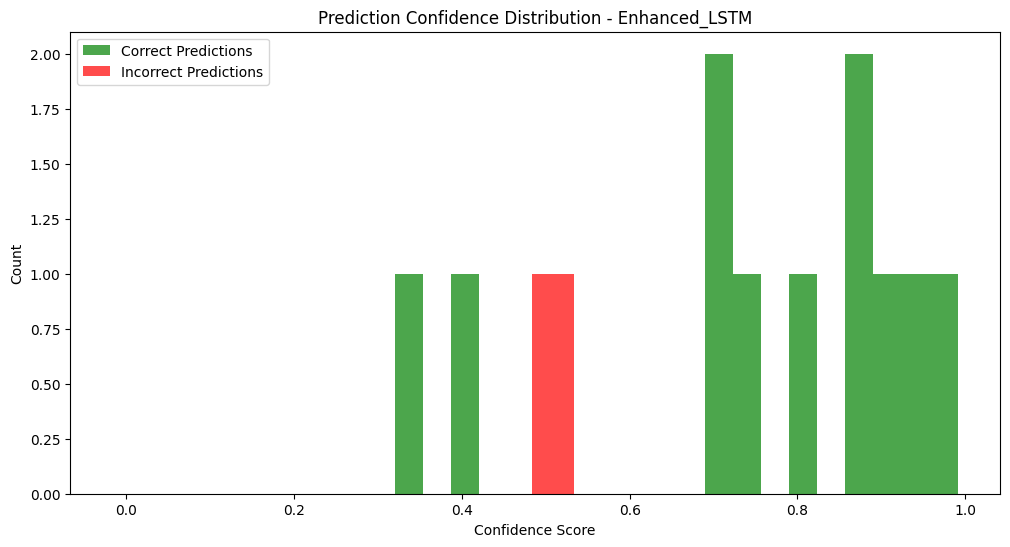

Enhanced_LSTM Test Accuracy: 0.9167

Enhanced_LSTM - Chord Performance Metrics:
Chord  | Precision  |   Recall   |  F1-Score 
------------------------------------------
A      |   1.0000   |   1.0000   |   1.0000  
A#     |   1.0000   |   1.0000   |   1.0000  
B      |   1.0000   |   1.0000   |   1.0000  
C      |   1.0000   |   1.0000   |   1.0000  
C#     |   0.5000   |   1.0000   |   0.6667  
D      |   1.0000   |   1.0000   |   1.0000  
D#     |   1.0000   |   1.0000   |   1.0000  
E      |   0.0000   |   0.0000   |   0.0000  
F      |   1.0000   |   1.0000   |   1.0000  
F#     |   1.0000   |   1.0000   |   1.0000  
G      |   1.0000   |   1.0000   |   1.0000  
G#     |   1.0000   |   1.0000   |   1.0000  

Average confidence for correct predictions: 0.7494
Average confidence for incorrect predictions: 0.4831


In [133]:
def evaluate_model(model, test_loader, label_encoder, model_name):
    """Evaluate model on test set with detailed analysis"""
    model.eval()
    all_preds = []
    all_targets = []
    all_probs = []  # Store prediction probabilities
    
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            probabilities = F.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
            all_probs.extend(probabilities.cpu().numpy())
    
    # Calculate accuracy
    accuracy = accuracy_score(all_targets, all_preds)
    
    # Decode to chord names
    target_chords = label_encoder.inverse_transform(all_targets)
    pred_chords = label_encoder.inverse_transform(all_preds)
    
    # Generate classification report
    class_report = classification_report(
        target_chords, pred_chords, output_dict=True
    )
    
    # Create confusion matrix
    cm = confusion_matrix(target_chords, pred_chords)
    
    # Plot enhanced confusion matrix
    plt.figure(figsize=(15, 12))
    chord_labels = label_encoder.classes_
    
    # Normalize confusion matrix for better visualization
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Plot both raw counts and normalized percentages
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    
    # Raw counts
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=chord_labels, yticklabels=chord_labels, ax=ax1)
    ax1.set_title(f'Confusion Matrix (Counts) - {model_name}')
    ax1.set_xlabel('Predicted Chord')
    ax1.set_ylabel('True Chord')
    
    # Normalized percentages
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Oranges', 
                xticklabels=chord_labels, yticklabels=chord_labels, ax=ax2)
    ax2.set_title(f'Confusion Matrix (Normalized) - {model_name}')
    ax2.set_xlabel('Predicted Chord')
    ax2.set_ylabel('True Chord')
    
    plt.tight_layout()
    plt.savefig(f'confusion_matrix_{model_name}.png')
    plt.show()
    
    # Calculate confidence metrics
    all_probs = np.array(all_probs)
    pred_confidence = np.max(all_probs, axis=1)
    
    # Plot prediction confidence distribution
    plt.figure(figsize=(12, 6))
    
    # For correct predictions
    correct_mask = np.array(all_preds) == np.array(all_targets)
    plt.hist(pred_confidence[correct_mask], alpha=0.7, bins=20, 
             label='Correct Predictions', color='green')
    
    # For incorrect predictions
    if not all(correct_mask):
        plt.hist(pred_confidence[~correct_mask], alpha=0.7, bins=20, 
                label='Incorrect Predictions', color='red')
    
    plt.title(f'Prediction Confidence Distribution - {model_name}')
    plt.xlabel('Confidence Score')
    plt.ylabel('Count')
    plt.legend()
    plt.savefig(f'confidence_distribution_{model_name}.png')
    plt.show()
    
    print(f"{model_name} Test Accuracy: {accuracy:.4f}")
    
    # Print chord-wise performance metrics
    chord_metrics = {}
    for chord, metrics in class_report.items():
        if chord not in ['accuracy', 'macro avg', 'weighted avg']:
            chord_metrics[chord] = metrics['f1-score']
    
    sorted_chords = sorted(chord_metrics.items(), key=lambda x: x[1], reverse=True)
    
    print(f"\n{model_name} - Chord Performance Metrics:")
    print(f"{'Chord':<6} | {'Precision':^10} | {'Recall':^10} | {'F1-Score':^10}")
    print("-" * 42)
    
    for chord in sorted(chord_metrics.keys()):
        metrics = class_report[chord]
        print(f"{chord:<6} | {metrics['precision']:^10.4f} | {metrics['recall']:^10.4f} | {metrics['f1-score']:^10.4f}")
    
    # Calculate average confidence
    avg_conf_correct = np.mean(pred_confidence[correct_mask]) if any(correct_mask) else 0
    avg_conf_incorrect = np.mean(pred_confidence[~correct_mask]) if not all(correct_mask) else 0
    
    print(f"\nAverage confidence for correct predictions: {avg_conf_correct:.4f}")
    if not all(correct_mask):
        print(f"Average confidence for incorrect predictions: {avg_conf_incorrect:.4f}")
    
    return accuracy, class_report

# Evaluate the enhanced model
print("\n=== Enhanced LSTM Model Evaluation ===")
lstm_accuracy, lstm_report = evaluate_model(
    lstm_model, test_loader, progression_dataset.label_encoder, "Enhanced_LSTM"
)